# The scenario

The housing market is one of the most crucial parts of the economy for every country. Purchasing a home is one of the primary ways to build wealth and savings for people. In this respect, predicting prices in the housing market is a very central topic in economic and financial circles.

The house price dataset from Kaggle includes several features of the houses along with their sale prices at the time they are sold. So far, in this module, you built and implemented some models using this dataset.

In this challenge, you are required to improve your model with respect to its prediction performance.

To complete this challenge, submit a Jupyter notebook containing your solutions to the following tasks.

In [1]:
from itertools import permutations
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats.mstats import winsorize
from scipy.stats import boxcox, jarque_bera, normaltest
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine
from IPython.display import Markdown, display

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format
def printmd(string):
    "prints text in bold"
    display(Markdown(string))

import warnings
warnings.filterwarnings(action="ignore")


# Load the houseprices data from Thinkful's database.

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.000,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


# Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But make sure that your work is satisfactory.


First and foremost, let's bring the saleprice column to the front:

In [3]:
# get a list of columns
cols = list(df)

# move the column to head of list using index, pop and insert
cols.insert(0, cols.pop(cols.index('saleprice')))

# use ix to reorder
df = df.ix[:, cols]

## Exploratory Data Analysis

First, let's take a look at our target model's distribution:

Mean: $180921.0


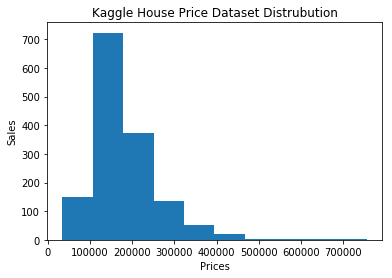

In [4]:
print('Mean: ${}'.format(round(np.mean(df.saleprice))))
plt.hist(df.saleprice)
plt.title('Kaggle House Price Dataset Distrubution')
plt.xlabel('Prices')
plt.xticks()
plt.ylabel('Sales')
plt.show()

The target variable is right-skewed with a somewhat high peak in terms of kurtosis. The mean is 180,921 and prices reach a stretch above 700,000. Let's check how much of the data is captured:

#### Missing Values & Data types

Let's take a look at the missing data and data types:

In [5]:
#count missing values
missing_vals = (df.isnull().sum()/len(df)).sort_values(ascending=False)

# keep column names that do have them
missing_vals = missing_vals[missing_vals > 0]

# data types
missValDTypes = df[missing_vals.index.to_list()].dtypes

printmd("**Missing value percentages:** Total values: {}".format(len(df)))
print(missing_vals, '\n')
printmd("**Data types of missing values:**")
print(missValDTypes)


# del missing_vals
# del missValDTypes

**Missing value percentages:** Total values: 1460

poolqc         0.995
miscfeature    0.963
alley          0.938
fence          0.808
fireplacequ    0.473
lotfrontage    0.177
garageyrblt    0.055
garagequal     0.055
garagecond     0.055
garagefinish   0.055
garagetype     0.055
bsmtexposure   0.026
bsmtfintype2   0.026
bsmtfintype1   0.025
bsmtqual       0.025
bsmtcond       0.025
masvnrarea     0.005
masvnrtype     0.005
electrical     0.001
dtype: float64 



**Data types of missing values:**

poolqc           object
miscfeature      object
alley            object
fence            object
fireplacequ      object
lotfrontage     float64
garageyrblt     float64
garagequal       object
garagecond       object
garagefinish     object
garagetype       object
bsmtexposure     object
bsmtfintype2     object
bsmtfintype1     object
bsmtqual         object
bsmtcond         object
masvnrarea      float64
masvnrtype       object
electrical       object
dtype: object


# Replace the first few missing values with 0. drop the entire column when missing vals are by random.

Looking at missing values, the first few features from poolqc to lotfrontage are amenities/features that do not exist in many houses. From garagecond to garagequal are garage-related features that are missing values for a specific group of rows, which most probably does not have garages. The same goes for the features from bsmtexposure to bsmtqual, masvnrarea, and masvnrtype.

For each of these cases of missing values, there will be a suitable way to fill these values. Columns with over 40% of missing values will be dropped since they relate only to a minority subset of the houses sold, and when they do, they may have low correlation with the saleprice. We will also confirm or remove this doubt after checking for correlation. Most columns have string data types, only 3 are floats. For now, let's store each *case* of missing data as a key for later use:

In [6]:
# Columns to be dropped, pending correlation values
drop_cols = missing_vals[:5].index.to_list()
drop_cols.extend(['id'])

# Columns to be dealt with by case
data_cleaning = {'garage':[i for i in missing_vals.index.to_list() if i.startswith('garage')],
                 'basement':[i for i in missing_vals.index.to_list() if i.startswith('bsmt')],
                 'etc':['masvnrarea','masvnrtype','electrical']}

#### Descriptive Statistics
Since it is tedious to describe a whole dataset from which we will select only some features, we shall focus on the target varaible in hope of understanding realistic target values, their distribution and where a certain predicted value would fall within the distribution.

In [7]:
df['saleprice'].describe()

count     1460.000
mean    180921.196
std      79442.503
min      34900.000
25%     129975.000
50%     163000.000
75%     214000.000
max     755000.000
Name: saleprice, dtype: float64

If you are located in the U.S, this would seem like a realistic and normal dataset. Some houses can be sold for as low as 34,900 due to their age, location, type, or any other attribute. A house in the same city but in a different neighborhood can reach 755,000 and would probably have a more luxurious set of amenities included. 

The median for most buyers is 163,000, which is less than the 180,921 mean. This validates our finding in the distribution plot above that the data is not normally distributed.

Let us take a look at the correlation of our data, moving the target column to the front and ordering rows by their correlation with it:

### Univariate & Multivariate Analysis

Starting with univariate analysis, let's draw distributions of features:

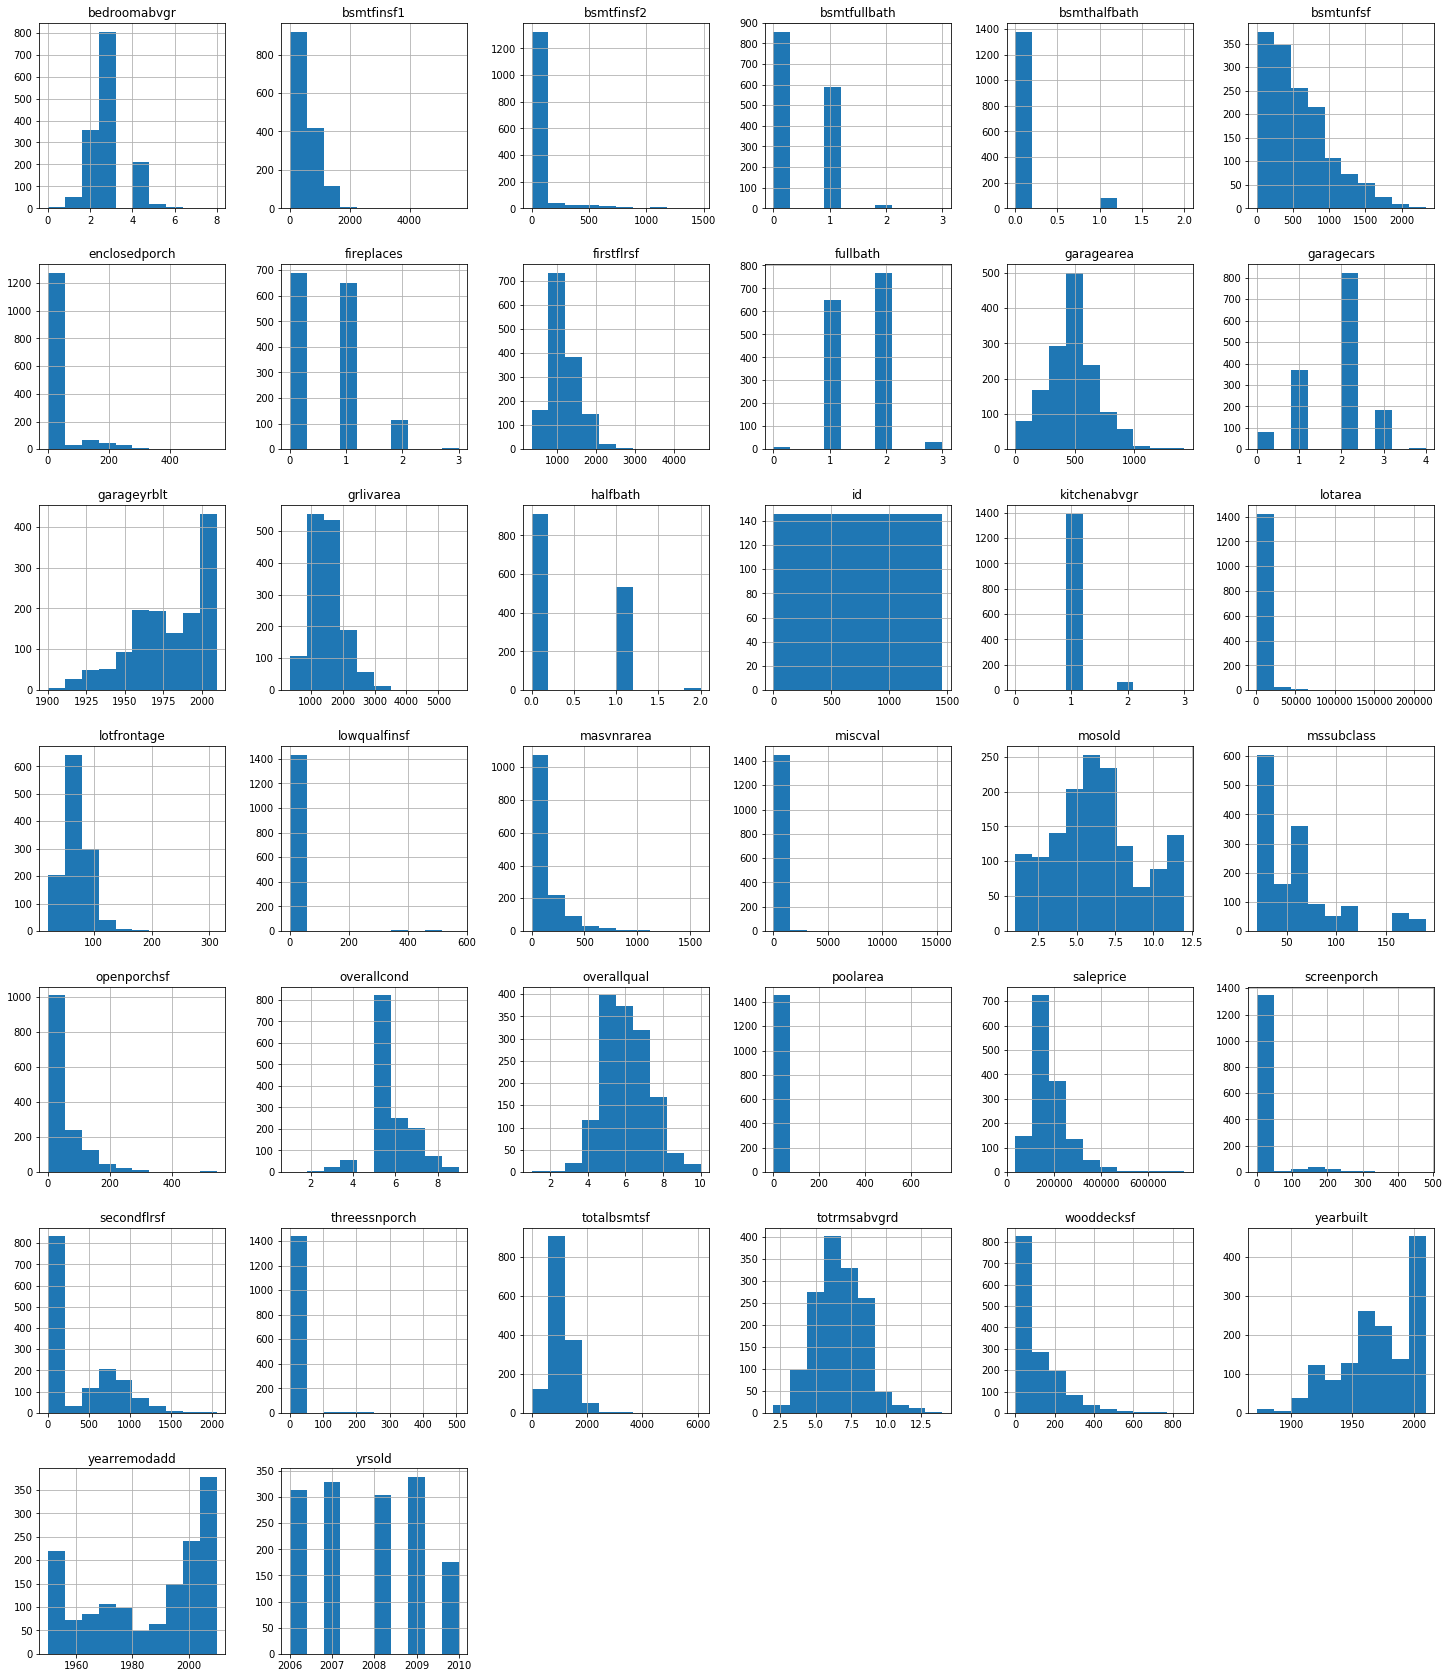

In [8]:
df.hist(figsize=(25,30))
plt.show()

Most features are not normally distributed. This goes against one of assumptions for regression models. 

## Data Cleaning

Up until here, and before we go into multivariate analysis, we have been exploring feature distributions, missing data, and data types. We have decided on a few columns for removal. It makes sense to clean the values we have and check for any improvement in their distribution. Let's begin by removing columns we want to drop:

In [9]:
# Drop columns marked for removal
df.drop(columns=drop_cols, inplace=True)
df = df.replace([np.inf, -np.inf], np.nan).dropna(how="all")

# Deal with missing values
for key in data_cleaning.keys():
    print(key)
    for val in data_cleaning[key]:
        print (val)
        if len(df[val].value_counts()) <= 7:
            print("{}".format(df[val].value_counts()))
        else:
            print("{}".format(df[val].describe()))


garage
garageyrblt
count   1379.000
mean    1978.506
std       24.690
min     1900.000
25%     1961.000
50%     1980.000
75%     2002.000
max     2010.000
Name: garageyrblt, dtype: float64
garagequal
TA    1311
Fa      48
Gd      14
Po       3
Ex       3
Name: garagequal, dtype: int64
garagecond
TA    1326
Fa      35
Gd       9
Po       7
Ex       2
Name: garagecond, dtype: int64
garagefinish
Unf    605
RFn    422
Fin    352
Name: garagefinish, dtype: int64
garagetype
Attchd     870
Detchd     387
BuiltIn     88
Basment     19
CarPort      9
2Types       6
Name: garagetype, dtype: int64
basement
bsmtexposure
No    953
Av    221
Gd    134
Mn    114
Name: bsmtexposure, dtype: int64
bsmtfintype2
Unf    1256
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: bsmtfintype2, dtype: int64
bsmtfintype1
Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
Name: bsmtfintype1, dtype: int64
bsmtqual
TA    649
Gd    618
Ex    121
Fa     35
Name: bsmtqual, dtype: int64
bsm

Based on these values and their counts or description, we will fill in missing values accordingly:

In [10]:
# Create a dictionary containing the value to replace missing values in each column
fill_with = {'garageyrblt': 0, 'garagequal': 'TA', 'garagecond': 'TA', 'garagefinish': 'Unf','garagetype':'No',
             'bsmtexposure':'No','bsmtfintype2':'Unf','bsmtfintype1':'Unf','bsmtqual':'TA','bsmtcond':'TA',
             'masvnrarea':0,'masvnrtype':'None','electrical':'SBrkr'}
df = df.fillna(value=fill_with)

Next, let's transform numerical values and try to reach distributions close to normal. Since it is hard to visualize the normality in all columns at once, we will use the Jargue-Bera and normality tests:

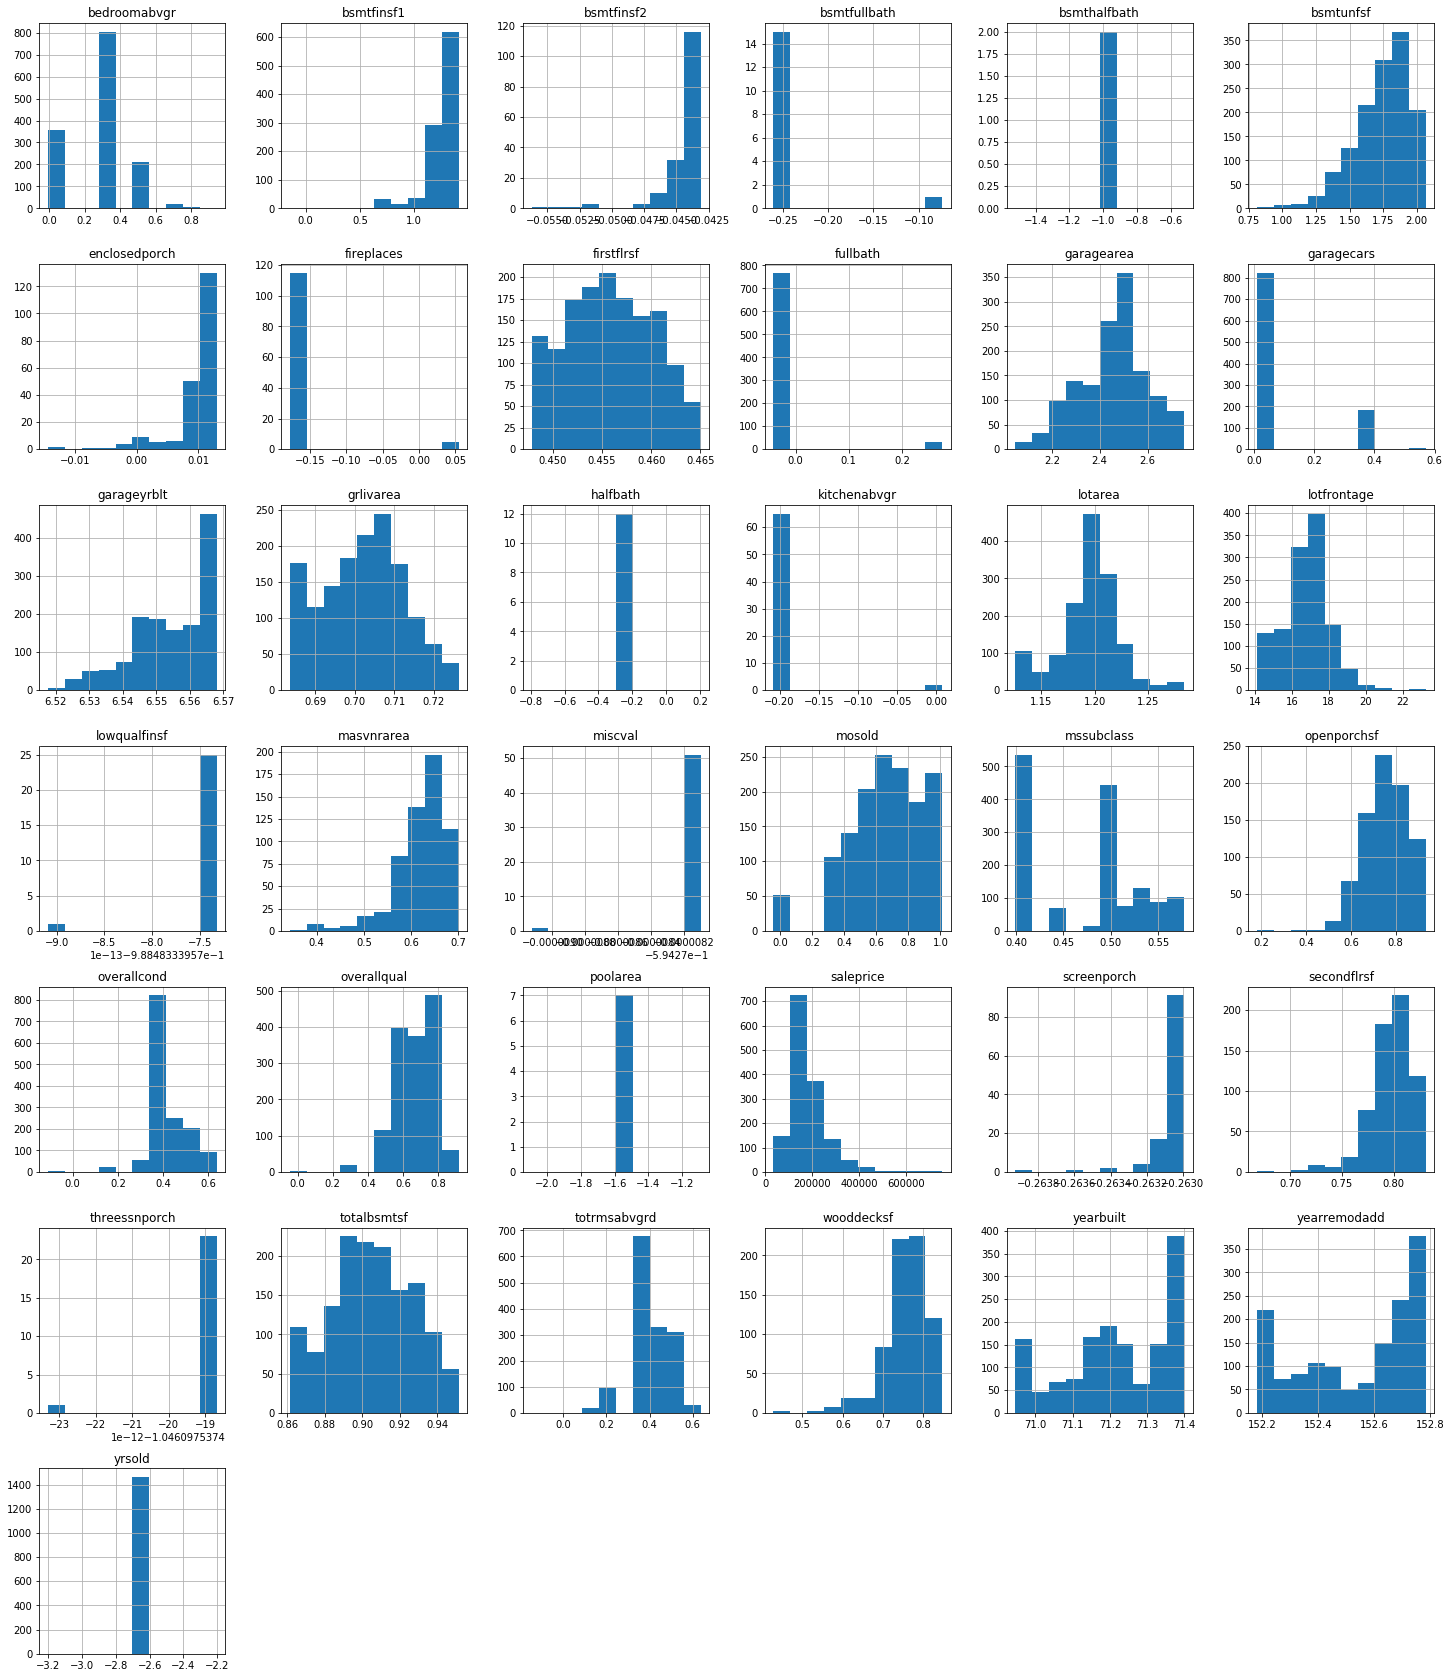

In [11]:
def transform(df, target, transformations=[],box_cox=False):
    """ Winsorizes, transforms, and cleans numeric columns 
        transformations parameter is a list of functions fed to pd.series.apply(), repectively.
        returns transformed dataframe
    """
    
    def bxcx_prep(val):
        """ Transforms values of 0 or less to 0.1 """
    
        if val <= 0:
            return 0.1
        return val
    
    # Pick numerical columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.to_list()
    numeric_cols.remove(target)
    
    # Winsorize, log-transform the square root, and plot
    for col in numeric_cols:
        if len(np.unique(df[col])) > 20:
            df[col] = winsorize(df[col], limits = (0.05,0.01))
        if box_cox or any(item in transformations for item in [np.log,np.sqrt]):
            df[col] = df[col].apply(bxcx_prep)
            df[col],_ = boxcox(df[col])
        for transformation in transformations:
            df[col] = df[col].apply(transformation)
        df = df.replace([np.inf, -np.inf], np.nan).dropna(how="all")
    return df

transform(df,'saleprice',[np.sqrt,np.log]).hist(figsize=(25,30)) #[np.sqrt,np.log]
plt.show()

Winsorizing and transforming values did bring distribution of some variables closer to normal. This should contribute to enhancing our regression models.

How do these different values affect saleprice? Let's start by taking a look at values of each categorical feature in terms of saleprice. This enables us to see how each value affects the saleprice and how it differs from another value for the same feature:

# Add explanation

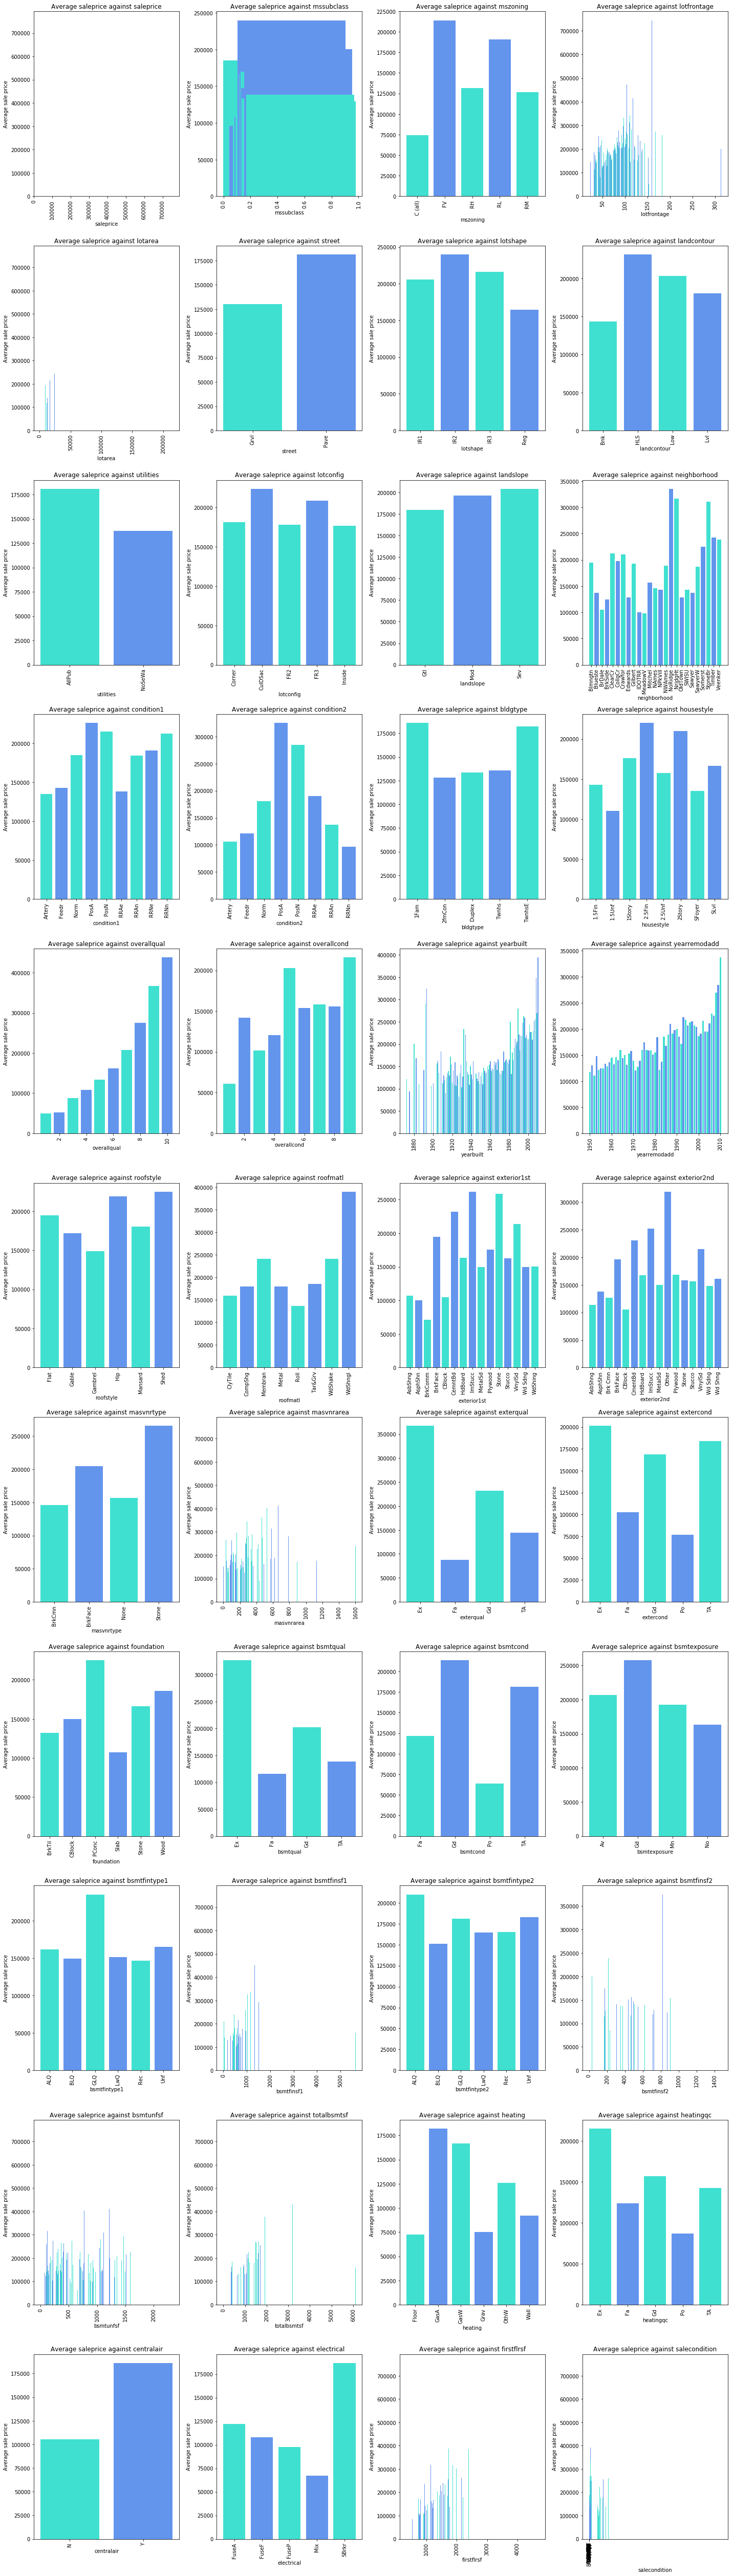

In [12]:
# Plot different bar plots for features against the target
plt.figure(figsize=(20,70))
i = 1
for index, column in enumerate(df.columns):
    plt.subplot(11,4,i)
    
    # Fix this bug: index difference 0,1
    if i < 44:
        i += 1
    else:
        i = 44
    
    plt.bar(df.groupby(column)["saleprice"].mean().index, df.groupby(column)["saleprice"].mean(),color=('turquoise','cornflowerblue'))
    plt.title("Average saleprice against {}".format(column))
    plt.ylabel("Average sale price")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

# Feature Engineering

The multi-plot figure above makes it easy to see relationships of features with the target. Neighborhoods, street paving, heating and other variables. Since we are looking at a dataset of house sales, one good way to start is by looking at prices across neighborhoods. Houses of the same neighborhood are usually sold for a price within a fixed range for that neighborhood, **that price usually encompasses several attributes like lot size, land class, year built and others**, possibly making it a highly-correlated feature in our model. 

Additionally, seeing the count of each value in the target variable will enable us to see how much training data for each value -or *range* of values, given our problem-  is available. Since house prices are a continuous variable, it makes sense to bin these prices into preset bins that makes sense to us.

It also makes sense to order this view from highest to lowest price to see how fast the price changes downwards:

In [28]:
print('\n')
printmd('**Neighborhoods - typical values ordered from most to least expensive**')
# Group data by neighborhood
df.groupby("neighborhood").mean().sort_values(by=['saleprice'],ascending=False)

**Neighborhoods - typical values ordered from most to least expensive**

,saleprice,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,neighborhood_class
neighborhood,,,,,,,,,,,,,,,,,,,,,
NoRidge,335295.317,0.488,91.879,14218.902,7.927,5.220,1995.439,1996.659,420.024,829.756,...,200.220,75.122,29.244,0.000,13.512,13.537,0.000,6.244,2007.829,2.488
NridgHt,316270.623,0.475,81.882,10887.948,8.260,5.000,2005.675,2006.169,329.545,696.779,...,151.701,75.532,0.000,3.948,15.039,0.000,0.000,6.857,2007.818,2.455
StoneBr,310499.000,0.501,62.700,10671.920,8.160,5.000,1998.480,1998.840,182.760,822.920,...,164.960,51.080,25.920,6.720,27.760,0.000,0.000,7.640,2007.920,2.280
Timber,242247.447,0.441,80.133,23664.237,7.158,5.132,1992.842,1993.342,159.947,708.500,...,143.842,50.789,10.342,0.000,15.421,0.000,18.421,5.921,2007.816,1.895
Veenker,238772.727,0.473,59.714,15606.000,6.727,6.273,1982.364,1989.818,32.727,819.909,...,190.545,50.182,0.000,0.000,56.364,0.000,0.000,7.000,2007.000,1.727
Somerst,225379.837,0.484,64.667,7840.872,7.337,5.035,2004.988,2005.302,150.326,327.198,...,69.174,101.174,0.000,0.000,5.395,0.000,0.000,6.233,2007.744,1.733
ClearCr,212565.429,0.476,83.462,30875.750,5.893,5.679,1966.571,1983.750,84.571,620.893,...,188.821,64.821,32.536,4.643,34.929,0.000,32.143,6.786,2007.786,1.607
Crawfor,210624.725,0.484,71.805,11809.686,6.275,6.588,1941.549,1979.196,81.118,466.804,...,52.569,27.000,46.176,10.804,30.176,0.000,49.020,6.863,2007.490,1.588
CollgCr,197965.773,0.452,71.683,9619.147,6.640,5.240,1997.887,1999.140,97.227,456.587,...,114.320,51.720,0.227,2.593,4.300,0.000,16.333,6.140,2007.807,1.500


NoRidge, NridgHt and StoneBr are the most expensive neighborhoods in this dataset. Some of their features are significantly different than those of other neighborhoods. Note that the bin numbers are:
    
    0 = fair
    1 = good
    2 = very good
    3 = luxurious
    
We will define a function & name it *classify_nbr* to add our own neighborhood categories to the dataset:

In [14]:
def classify_nbr(saleprice):
    """ puts houses in preset neighborhood bins """
    
    nbr_class = {0:'saleprice < 120000',
                 1:'saleprice >= 120000 and saleprice < 200000',
                 2:'saleprice >= 200000 and saleprice < 300000',
                 3:'saleprice >= 300000'}
    for class_level in nbr_class.keys():
        if eval(nbr_class[class_level]):
            return class_level

df['neighborhood_class'] = df['saleprice'].apply(classify_nbr)

In [15]:
# make the correlation matrix.
corr_mat_houses = df.corr()

printmd('\n **Correlation dataframe sorted by correlation with saleprice descending:**')
corr_mat_houses.sort_values(by=['saleprice'],ascending=False)


 **Correlation dataframe sorted by correlation with saleprice descending:**

,saleprice,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,neighborhood_class
saleprice,1.000,-0.021,0.352,0.264,0.791,-0.078,0.523,0.507,0.473,0.386,...,0.324,0.316,-0.129,0.045,0.111,0.092,-0.021,0.046,-0.029,0.892
neighborhood_class,0.892,-0.035,0.348,0.247,0.755,-0.059,0.539,0.523,0.401,0.374,...,0.319,0.314,-0.131,0.053,0.096,0.043,-0.020,0.057,-0.023,1.000
overallqual,0.791,0.086,0.252,0.106,1.000,-0.092,0.572,0.551,0.407,0.240,...,0.239,0.309,-0.114,0.030,0.065,0.065,-0.031,0.071,-0.027,0.755
grlivarea,0.709,0.224,0.403,0.263,0.593,-0.080,0.199,0.287,0.388,0.208,...,0.247,0.330,0.009,0.021,0.102,0.170,-0.002,0.050,-0.037,0.652
garagecars,0.640,-0.007,0.286,0.155,0.601,-0.186,0.538,0.421,0.362,0.224,...,0.226,0.214,-0.151,0.036,0.050,0.021,-0.043,0.041,-0.039,0.626
garagearea,0.623,-0.075,0.345,0.180,0.562,-0.152,0.479,0.372,0.371,0.297,...,0.225,0.241,-0.122,0.035,0.051,0.061,-0.027,0.028,-0.027,0.613
totalbsmtsf,0.614,-0.297,0.392,0.261,0.538,-0.171,0.391,0.291,0.360,0.522,...,0.232,0.247,-0.095,0.037,0.084,0.126,-0.018,0.013,-0.015,0.588
firstflrsf,0.606,-0.305,0.457,0.299,0.476,-0.144,0.282,0.240,0.340,0.446,...,0.235,0.212,-0.065,0.056,0.089,0.132,-0.021,0.031,-0.014,0.566
fullbath,0.561,0.190,0.199,0.126,0.551,-0.194,0.468,0.439,0.273,0.059,...,0.188,0.260,-0.115,0.035,-0.008,0.050,-0.014,0.056,-0.020,0.529
totrmsabvgrd,0.534,0.192,0.352,0.190,0.427,-0.058,0.096,0.192,0.280,0.044,...,0.166,0.234,0.004,-0.007,0.059,0.084,0.025,0.037,-0.035,0.498


The columns we have chosen as features before can be seen in the top rows. None of the negatively correlated features are significant enough to include within the model's features. To visualize this table, let's draw a correlation matrix, filtering out correlation less than a set threshold for a focused view on relevant features:

**Correlation Matrix (filtered for correlation above 0.64):**

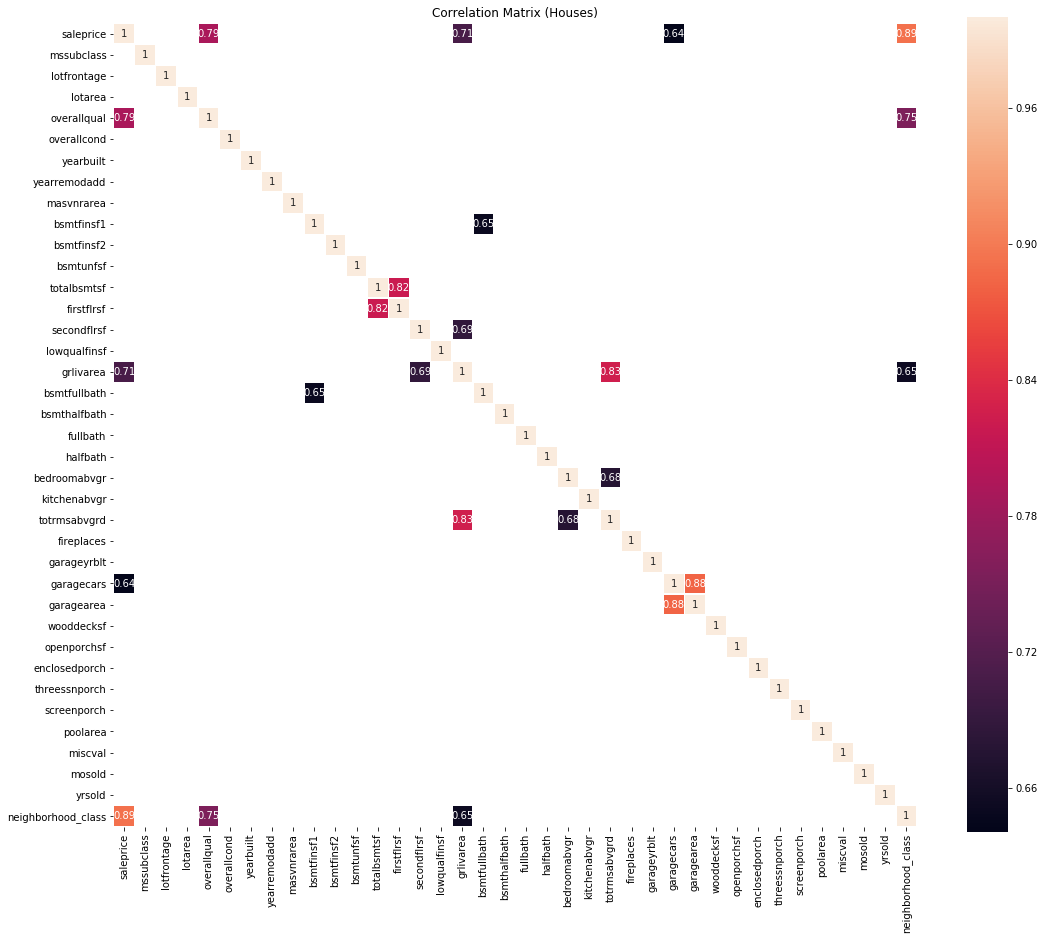

features are: ['overallqual', 'grlivarea', 'garagecars', 'neighborhood_class']


In [16]:
def draw_heatmap(df,corr_thresh=.7):
    """ Draws heatmap out of a dataframe. 
        Set corr_thresh to 0 for full heatmap,
        or keep default for strong correlation
    """
    
    # make the correlation matrix.
    corr_mat = df.corr()

    # move the column to head of list using index, pop and insert
    cols = list(corr_mat)
    cols.insert(0, cols.pop(cols.index('saleprice')))

    # reorder
    corr_mat = corr_mat.ix[:, cols]
    corr_mat.sort_values(by=['saleprice'],ascending=False)

    # figure aesthetics
    plt.figure(figsize=(18,15))
    plt.plot()
    
    # draw the heatmap using seaborn.
    sns.heatmap(corr_mat[(corr_mat > corr_thresh)], square=True, annot=True, linewidths=.5)
    plt.title("Correlation Matrix (Houses)")
    printmd("**Correlation Matrix (filtered for correlation above {}):**".format(corr_thresh))
    plt.show()
    
    # return features that correlate with the target equal to corr_thresh or higher
    features = corr_mat[(corr_mat > corr_thresh)]
    features = features.index[features['saleprice'] >= corr_thresh].tolist()
    features.remove('saleprice')
    print('features are: {}'.format(features))
    return features

corr_thresh = 0.64
features = draw_heatmap(df,corr_thresh)


    
# del corr_mat_houses

Several values were tried in order to choose a threshold. Our correlation threshold here is 0.64. This will be the _initial_ basis on which we base our feature selection. Let's build our second model based on features selected, removing overallqual and grlivarea since they both have high correlation with neighborhood_class :

In [17]:
# Initial model prep
temp_df = df[['saleprice',
              'overallqual',
              'grlivarea',
              'garagecars']]

def log_prep(temp_df):
    """takes in the chosen temp_df for the model and outputs X & Y with saleprice log-transformed"""
    
    # Log-transform salesprice values & drop saleprice
    temp_df['saleprice_log'] = np.log(temp_df['saleprice'])
    temp_df.drop(columns=['saleprice'],inplace=True)
    
    # designate features
    features = list(temp_df.columns)
    features.remove('saleprice_log')
    print('features (len: {}): {}\ntarget: {}'.format(len(features),{i for i in features},list(set(set(temp_df.columns)-set(features)))))

    # X & Y
    X = temp_df[features]
    Y = temp_df['saleprice_log']
    return X,Y

X, Y = log_prep(temp_df)

features (len: 3): {'grlivarea', 'overallqual', 'garagecars'}
target: ['saleprice_log']


It seems that PCA is not needed for this specific model as the features are few. Since we will be building several models, we will come back to this step at some point and perform some more feature engineering.

# Now, split your data into train and test sets where 20% of the data resides in the test set.

In [18]:
X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)


# Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!


## OLS

#### Model 1 : 



This is the model we built up until now in this challenge. The following features are based on 0.7 or more correlation, and overallqual and grlivarea are removed due to correlating strongly with neighborhood_class :

# Try sklearn CV linear regression

In [19]:
features_1 = ['saleprice', 'neighborhood_class', 'garagecars']
temp_df = df[features_1]

results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          saleprice_log   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     1336.
Date:                Sat, 26 Oct 2019   Prob (F-statistic):               0.00
Time:                        12:40:57   Log-Likelihood:                 292.72
No. Observations:                1168   AIC:                            -577.4
Df Residuals:                    1164   BIC:                            -557.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          10.5812      0.025    417.163      0.000      10.531      10.631
overallqual     0.1451      0.006     25.463      0.000       0.134       0.156
grlivarea       0.0002   1.32e-05     16.294      0.000       0.000       0.000
garagecars      0.1316      0.010     13.826      0.000       0.113       0.150
==============================================================================
Omnibus:                      376.882   Durbin-Watson:                   1.887
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2581.221
Skew:                          -1.311   Prob(JB):                         0.00
Kurtosis:                       9.794   Cond. No.                     7.49e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.49e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Model 2 : From previous lessons

This is the most up-to-date model from previous lessons.

In [20]:
# Initial model prep
features_2 = ['saleprice','overallqual','grlivarea',
              'garagecars', 'totalbsmtsf', 'fullbath',
              'yearbuilt', 'yearremodadd']
temp_df = df[features_2]

X, Y = log_prep(temp_df)

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

features (len: 7): {'garagecars', 'overallqual', 'totalbsmtsf', 'fullbath', 'grlivarea', 'yearremodadd', 'yearbuilt'}
target: ['saleprice_log']


In [21]:
results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          saleprice_log   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     712.1
Date:                Sat, 26 Oct 2019   Prob (F-statistic):               0.00
Time:                        12:40:57   Log-Likelihood:                 395.39
No. Observations:                1168   AIC:                            -774.8
Df Residuals:                    1160   BIC:                            -734.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3.2966      0.658      5.006      0.000       2.005       4.589
overallqual      0.0980      0.006     15.935      0.000       0.086       0.110
grlivarea        0.0002   1.53e-05     15.616      0.000       0.000       0.000
garagecars       0.0912      0.009      9.815      0.000       0.073       0.109
totalbsmtsf      0.0001    1.4e-05      8.035      0.000    8.51e-05       0.000
fullbath        -0.0160      0.013     -1.189      0.235      -0.042       0.010
yearbuilt        0.0017      0.000      6.452      0.000       0.001       0.002
yearremodadd     0.0021      0.000      6.567      0.000       0.001       0.003
==============================================================================
Omnibus:                      797.249   Durbin-Watson:                   1.855
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            30517.342
Skew:                          -2.623   Prob(JB):                         0.00
Kurtosis:                      27.486   Cond. No.                     4.38e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.38e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R2 & Adj. R-squared are 1, which is high. The F-statistic is higher, the AIC and BIC are lower than the ones seen previously, which means the additional features in the model are contributing additional information. This model has performed better than the one we developed in this challenge so far in . Since these two models carry the best features based on correlation, it would be a good idea to combine their features in a third model.

#### Model 3

This model will take features from Model 1 and adds to it features from Model 2 that have low multicollinearity. This means we will be removing overallqual and grlivarea from Model 3:

In [22]:
features_3 = list(set(features_1 + features_2)-set(['overallqual','grlivarea']))
temp_df = df[features_3]

X, Y = log_prep(temp_df)

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)
print(features_3)

features (len: 6): {'garagecars', 'neighborhood_class', 'totalbsmtsf', 'fullbath', 'yearremodadd', 'yearbuilt'}
target: ['saleprice_log']
['garagecars', 'neighborhood_class', 'saleprice', 'totalbsmtsf', 'fullbath', 'yearremodadd', 'yearbuilt']


In [23]:
results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          saleprice_log   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     1485.
Date:                Sat, 26 Oct 2019   Prob (F-statistic):               0.00
Time:                        12:40:57   Log-Likelihood:                 683.47
No. Observations:                1168   AIC:                            -1353.
Df Residuals:                    1161   BIC:                            -1318.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  8.5487      0.483     17.688      0.000       7.600       9.497
garagecars             0.0697      0.007      9.617      0.000       0.055       0.084
neighborhood_class     0.3345      0.007     44.701      0.000       0.320       0.349
totalbsmtsf         7.534e-05   1.09e-05      6.906      0.000    5.39e-05    9.67e-05
fullbath               0.0765      0.009      8.624      0.000       0.059       0.094
yearremodadd           0.0012      0.000      4.638      0.000       0.001       0.002
yearbuilt              0.0002      0.000      1.168      0.243      -0.000       0.001
==============================================================================
Omnibus:                      279.741   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1493.346
Skew:                          -0.999   Prob(JB):                         0.00
Kurtosis:                       8.166   Cond. No.                     3.66e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.66e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This third model is superior to both previous models and we can consider this model our best OLS model for now. Removing overallqual and grlivarea from Model II in order to replace them with neighborhood_class seems to have contributed a good bit to the model's .

## Ridge Regression

# PAY ATTENTION

In [24]:
# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced.
a = [1,2,3,4,10**37]
ridgeregr = Ridge(alpha=a) 
ridgeregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridgeregr.predict(X_train)
y_preds_test = ridgeregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

ValueError: Number of targets and number of penalties do not correspond: 5 != 1

## Lasso

In [ ]:
lassoregr = Lasso(alpha=10**20.5) 
lassoregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lassoregr.predict(X_train)
y_preds_test = lassoregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(lassoregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

## ElasticNet regression


In [ ]:
elasticregr = ElasticNet(alpha=10**21, l1_ratio=0.5) 
elasticregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticregr.predict(X_train)
y_preds_test = elasticregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(elasticregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

# SAME REG QUALITY METRICS DUE To having SIMILAR ALPHA VALS
# ALso try on diff dataset

# Evaluate your best model on the test set.



In [ ]:
# predict house prices using test set
y_preds = results.predict(X_test)

# plot results against actual values
plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test)
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("House prices: true vs. predicted values")
plt.show()

In [ ]:
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

The values for MAE, MSE, RMSE, and MAPE are satisfactory for Model 3 predictions.

# So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.


These variables can be obtained using the dates of house sales. Getting a range of years will enable us to obtain GDP (Gross Domestic Product), GNP (Gross National Product), and interest rate for the year of sale:

In [ ]:
'This dataset contains house sales made between {} and {}.'.format(min(df['yrsold']),max(df['yrsold']))

In [ ]:
# These values were obtained from Google (source: World Bank)
gdp = [13.86,14.48,14.72,14.42,14.96]
int_rate = [5.87, 5.4, 2, 0.5, 0.75]
yrs = [i for i in range(2006,2011)]
gdp = {i:n for i in yrs for n in gdp}
int_rate = {i:n for i in yrs for n in int_rate}

# add the 2 columns
df['gdp'] = [gdp[i] for i in df['yrsold']]
df['int_rate'] = [int_rate[i] for i in df['yrsold']]

#### Model 4

In [ ]:
features_4 = features_3
features_4.extend(['gdp','int_rate'])

temp_df = df[features_4]

X, Y = log_prep(temp_df)

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

results = sm.OLS(y_train, X_train).fit()

results.summary()

This model did not surpass Model 3 in any of the metrics. I would not expect it to perform any better than Model 3 when prediction:

In [ ]:
# predict house prices using test set
y_preds = results.predict(X_test)

# plot results against actual values
plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test)
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("House prices: true vs. predicted values")
plt.show()

In [ ]:
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

As expected, Model 4 prediction was not better than Model 3. This may be due to gdp and interest rates being very general metrics that need additional processing to be specific to this housing market. The column on which the new columns were added was the yrsold, which is the year the house was sold.

If quarterly values were available for this data, it would be expected that these columns would have higher coefficients in relation with the target.